# Evaluating BGP catchment on Tangled testbed (Compatible also with older anygility versions)

* Joao Ceron - ceron@botlog.org
* Leandro Bertholdo - leandro.bertholdo@gmail.com

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('default')

from IPython.display import display
from IPython.display import HTML

import matplotlib
%matplotlib inline
from matplotlib import ticker

import os.path
import re
import numpy as pynum_float

import warnings
warnings.filterwarnings('ignore')

In [2]:
# convert names to airport code (IATA)
di = {
		"au-syd-anycast01": "SYD",   "au-syd": "SYD", 
		"br-gru-anycast01": "GRU",   "br-gru": "GRU",
		"br-poa-anycast01": "POA",   "br-poa": "POA",
		"br-poa-anycast02": "POA",   "br-poa": "POA",
		"fr-par-anycast01": "CDG",   "fr-par": "CDG",
		"uk-lnd-anycast02": "LHR",   "uk-lnd": "LHR",
		"us-sea-anycast01": "SEA",   "us-sea": "SEA",
		"us-los-anycast01": "LAX",   "us-los": "LAX",
		"us-mia-anycast01": "MIA",   "us-mia": "MIA",
		"us-was-anycast01": "IAD",   "us-was": "IAD",
		"de-fra-anycast01": "FRA",   "de-fra": "FRA",
		"sg-sin-anycast01": "SIN",   "sg-sin": "SIN",
		"dk-cop-anycast01": "COP",   "dk-cop": "COP",
		"za-jnb-anycast01": "JNB",   "za-jnb": "JNB",
		"nl-ens-anycast02": "ENS",   "nl-ens": "ENS",
		"nl-ams-anycast01": "AMS",   "nl-ams": "AMS",
		"nl-arn-anycast01": "ARN",   "nl-arn": "ARN", 
		"jp-hnd-anycast01": "HND",   "jp-hnd": "HND", 
        'vultr-nodes'     : 'vultr-nodes',
        'ampath-nodes'    : 'ampath-nodes',
        'unknown'         : 'unknown',
        'baseline'        : 'baseline',
        'all'             : 'baseline'
} 

di_sites = {
		"au-syd": "au-syd-anycast01",    
		"br-gru": "br-gru-anycast01",    
		"br-poa": "br-poa-anycast01",    
		"br-poa": "br-poa-anycast02",    
		"fr-par": "fr-par-anycast01",    
		"uk-lnd": "uk-lnd-anycast02",    
		"us-sea": "us-sea-anycast01",    
		"us-los": "us-los-anycast01",    
		"us-mia": "us-mia-anycast01",    
		"us-was": "us-was-anycast01",    
		"de-fra": "de-fra-anycast01",    
		"sg-sin": "sg-sin-anycast01",    
		"dk-cop": "dk-cop-anycast01",    
		"za-jnb": "za-jnb-anycast01",    
		"nl-ens": "nl-ens-anycast02",    
		"nl-ams": "nl-ams-anycast01",    
		"nl-arn": "nl-arn-anycast01",    
		"jp-hnd": "jp-hnd-anycast01",    
}

# Select Input Dataset here

In [3]:

dir= "./stats_files/2020-04-04-1585997782-3-sites-used/compat-stats*.txt"
dir= "./stats_files/2020-04-08-1586357779-5-sites-used/compat-stats*.txt"
dir= "./stats_files/2020-04-05-1586099710-7-sites-used/compat-stats*.txt"

dir= "./stats_files/load-2019-12-06-1575649928/*load*.txt"

##dir = "./stats_files/load-4-sites/load-new*.txt"  # prepend 3-sites and community 4-sites
dir = "./stats_files/load-5-sites/load-new*.txt"  
dir = "./stats_files/load-6-sites/load-new*.txt"  
dir = "./stats_files/load-stats/load-new*.txt"


---
---
<h1 align="center">Functions</h1>

---
---

In [4]:
def init_fig(width=12,height=5):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot(111)   
    ax.set_facecolor("#ffffff")
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    fig.tight_layout();
    plt.style.use('default')
    
    return (fig,ax)

In [5]:
def get_and_plot_reference_value(df,site):

    
    df_site = df[df['site']==site].sort_values(by="bgp")
    reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]

    label = "[{}%] BASELINE".format(int(reference_value))
    # reference value annotation
    ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    # reference value line
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')

    return (reference_value)

In [6]:
def check_stats_file(fstats):
    ''' Check stats file if is consistent
        return: True is ok 
                False if is error
    '''
    # Check stats file for more than ohe header
    num_headers=0
    df=pd.read_csv(fstats,comment='#')
    try:
        num_headers=df['site'].value_counts()['site'] # found column name as column data
    except KeyError: 
        # not found 'site' as data... so its good
        return True
    
    # more than one header = two measurements in same file (measurement script with error)
    if num_headers:
        print (f'ERROR:: on file {fstats}')
        print (f'ERROR:: We found ({num_headers}) duplicated header on this file')
        print (f'ERROR:: Check your measurement! More than one measurement is overlapping to same filename!')
        return False
    
    return False


In [7]:
#------------------------------------------------------------------------------
def get_bgp_policy(fstats):
    ''' Extract BGP Routing policy from *.stas files 
    '''    
    policy="UNDEFINED"
    f = open(fstats, 'r')
    Lines = f.readlines() 
    for line in Lines:
        if re.match("#(bgp_)?policy", line):
            policy = line.split(",",1)[1].rstrip('\n')
        
            if ('UNDEFINED' in policy) or (policy=='#') or (policy==''):
                # keep searching another occurrence
                continue
                
    if ('UNDEFINED' in policy):
        print (f'UNDEFINED bgp policy in [{ftats}] ....')
    
    return policy

In [8]:
def read_stats_df(fstats):
    """ Read stat files solving compatibility issues with old file format
    """
    #print ("read_stats_df:: {}".format(filename))
    df=pd.read_csv(fstats,comment='#')
    
    # if do NOT have headers - assume old format and set a default header 
    is_header = not any(cell.isdigit() for cell in df.columns)
    if (not is_header):
        df=pd.read_csv(fstats,comment='#',names=["site", "counts", "percent"])
        
    return df

In [9]:
#------------------------------------------------------------------------------
from datetime import datetime
def get_header_fstats(fstats):
    ''' Extract data from Stats file header
    receive: stats file
    return: active_nodes, bgp_policy, date, 
    '''    
    policy='UNDEFINED'
    day=''
    nodes=''
    
    f = open(fstats, 'r')
    Lines = f.readlines() 
    for line in Lines:
        #bgp_policy or policy
        if (policy=='UNDEFINED'):
            if re.match("#(bgp_)?policy", line):
                policy = line.split(",",1)[1].rstrip('\n')
                if (policy=='#') or (policy==''):
                    # keep searching another occurrence
                    policy='UNDEFINED'
                    continue
                
        #date ou timestamp
        if not day:
            if re.match("#date", line):
                day = line.split(",",1)[1].rstrip('\n')
            if re.match("#timestamp", line):
                timestamp = int(line.split(",",1)[1].rstrip('\n'))
                day = datetime.fromtimestamp(timestamp)     
                
        #nodes
        if not nodes:
            if re.match("#active_nodes", line):
                nodes = line.split(",",1)[1].rstrip('\n')
                nodes = nodes.split(',')
                nodes.sort()
                # fix legacy mistake on measurement-scripts
                if 'ipv4' in nodes:
                    nodes.remove('ipv4')
                if 'unknown' in nodes:
                    nodes.remove('unknown')  
                # remove pinger if appear on stats (local interface)
                df=read_stats_df(fstats)
                df=df[df['counts']==1]['site']
                if len(df):
                    pinger=df.iloc[0]
                    pinger='-'.join(pinger.split('-')[:2])
                    if pinger in nodes:
                        nodes.remove(pinger)
        
    return (nodes, policy, day)

In [10]:
#------------------------------------------------------------------------------
def policy_eval(bgp):
    '''Evaluate BGP policy returning bgp_policy type, site where applied, 
    and values of prepends and communties if the case
    receive: bgp policy name from stats header (eg. community-20473:6000-au-syd)
    return: a pd.Series containg bgp_policy(community), location(au-syd),
            number_prepends(0 in this example), comunity_values(20473:6000)
    '''
    #print (f'policy_eval:: {bgp}')
    
    #baseline
    if 'baseline' in bgp:
        dic={'bgp_policy':'baseline', 
             'bgp_policy_location':'all', 
             'num_prepend':0, 
             'community':'None'
            }
        
    # community prepend 
    elif any(x in bgp for x in ['vultr','ampath']):
        #print (bgp)
        aux = re.search('.*-(\d)x-(\w+)-([a-z]{2}-[a-z]{3})*', bgp)      
        nprep = int(aux.group(1))
        location = aux.group(2)+'-nodes'
        site = aux.group(3)        
        policy = 'prepend-community'
        
        dic={'bgp_policy':policy,
             'bgp_policy_location':location, 
             'num_prepend':int(nprep), 
             'community':'None'
            }               
    
    #prepends
    elif any(x in bgp for x in ['prepend','positive','negative']):
        aux = re.search('.*-(\d)x-([a-z]{2}-[a-z]{3}).*', bgp)
        nprep = int(aux.group(1))
        site  = aux.group(2)
        
        if 'negative' in bgp:          
            nprep = nprep*-1
        
        dic={'bgp_policy':bgp,
             'bgp_policy_location':site, 
             'num_prepend':int(nprep), 
             'community':'None'
            }       
        
    #communities
    elif 'community' in bgp:
        aux=re.search('community-([0-9:,]+)-([a-z]{2}-[a-z]{3}).*', bgp)
        site  = aux.group(2)
        community = aux.group(1)
        
        dic={'bgp_policy':bgp,
             'bgp_policy_location':site, 
             'num_prepend':int(0), 
             'community':community
            }     

    #withdraw
    elif 'withdraw' in bgp:
        aux=re.search('withdraw-([a-z]{2}-[a-z]{3}).*', bgp)
        site  = aux.group(1)
        
        dic={'bgp_policy':bgp,
             'bgp_policy_location':site, 
             'num_prepend':int(0), 
             'community':'None'
            }     

    #unicast
    elif 'unicast' in bgp:
        aux=re.search('unicast-([a-z]{2}-[a-z]{3}).*', bgp)
        site  = aux.group(1)
        
        dic={'bgp_policy':bgp,
             'bgp_policy_location':site, 
             'num_prepend':int(0), 
             'community':'None'
            }            
        
    # not treated
    else:    
        dic={'bgp_policy':bgp, 
             'bgp_policy_location':'ERROR', 
             'num_prepend':int(0), 
             'community':'ERROR'
            }
        print (f'WARNING:: Not treatment for: \n{dic}')
        
    return pd.Series(dic)

In [11]:
#------------------------------------------------------------------------------
def remove_unknown_redo_percent(df):
    '''Recalculate all df percentages removing "unknown" answers'''
    
    df=df[df['site']!='unknown']
    tot=df['counts'].sum()
    df['percent']=(df['counts']/tot*100).round(2)
    return df

---
---
<h1 align="center">Read All stats files and build dataframe</h1>

---
---

In [12]:
# Empty df to all stats
df_all=pd.DataFrame(columns=['site','bgp'])

count = 0
fstats=''
for fstats in (glob.glob(dir)):
    count +=1
    filename = os.path.basename(fstats)
    print ("working on file: {}".format(fstats))
    
    # Check if statistics file is OK
    if not check_stats_file(fstats):
        print (f'This file is damaged --> {fstats}')
        print ('Skipping...\n')
        continue 
        
    # Read stats df
    df=read_stats_df(fstats)
    # if unknow site normalize percentage (TODO)

    
    # Read file header
    (nodes, bgp_policy, day) = get_header_fstats(fstats)
    #print (nodes, bgp_policy, day)
    
    df['bgp']=bgp_policy
    df['time']=day
    df['active_nodes']=','.join(nodes)
    
    #Check duplicated policies
    if not df_all.empty:
        pol_lst=df_all['bgp'].to_list()
        policy=df['bgp'][0]
        if policy in pol_lst :
            print(f"read_vpcli:: FOUND DUPLICATED POLICY AT {fstats}")
            print(f'WARNING::: This policy [{policy}] already exists!')
            print(f'Check if its ok for you! [{fstats}]')
            print ('Skipping...\n')
            continue    
            
    # remove "unknown" aswers and normalize percentage - we dont use this data here
    df=remove_unknown_redo_percent(df)   

    #
    # remove PINGER from stats (if just used as PINGER - no catchment site)
    #
    #find pinger
    recv_nodes=df['active_nodes'].drop_duplicates().to_list()[0].split(',')
    all_nodes=df['site'].drop_duplicates().str.replace('-anycast\d\d','').to_list()
    pinger=set(all_nodes)-set(recv_nodes)
    if (len(pinger)>=1):
        if (len(pinger)>1):
            print(f'WARNING:: maybe some issue here. Detected {len(pinger)}??? PINGER {pinger}')
            print(f'==>recv_nodes [{recv_nodes}] \n==>all_nodes [{all_nodes}] \n==>pinger [{pinger}] ')
            print(f'==> file: [{fstats}]')
        pinger=list(pinger)
    #print(f'PINGER:: recv_nodes [{recv_nodes}]  \nall_nodes [{all_nodes}]  \npinger [{pinger}] ')    
    # remove pinger
    pinger=list(map(di_sites.get, pinger))
    df=df[~df['site'].isin(pinger)]     

    # Add policy_eval information 
    df[['bgp_policy','bgp_policy_location','num_prepend','community']]=df['bgp'].apply(policy_eval)    
    
    # Append DF to playbook
    df_all=df_all.append(df)


# make [counts,num_prepend] as integers
df_all['num_prepend']=df_all['num_prepend'].astype(int)
df_all['counts']=df_all['counts'].astype(int)
    

# For compat with old notebook version
df_all.rename(columns={'counts':'count'}, inplace=True)

working on file: ./stats_files/load-stats/load-new-prepend-negative-3x-fr-par-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-positive-3x-uk-lnd-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-positive-2x-fr-par-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-negative-2x-uk-lnd-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-negative-4x-fr-par-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-positive-4x-uk-lnd-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-positive-1x-us-was-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-positive-1x-au-syd-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-positive-5x-fr-par-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-negative-5x-uk-lnd-1580512204.txt
working on file: ./stats_files/load-stats/load-new-prepend-negative-3x

---
---
<h1 align="center">Baseline Catchment</h1>

---
---

In [13]:
# Prepare df for plotting
df=df_all[['site', 'count', 'percent', 'time', 'bgp_policy_location','num_prepend', 'community', 'bgp_policy']].copy()
df['site']=df['site'].map(di)
df['bgp_policy_location']=df['bgp_policy_location'].map(di)

# remove prepend vs community prepend experiment from df (keep on df_all)
#df = df[~df['bgp_policy_location'].str.contains("nodes")]
df.head(2)

,site,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
0,CDG,1873298,55.49,2020-01-31-23:10:04,CDG,-3,None,prepend-negative-3x-fr-par-anycast01
1,IAD,507882,15.04,2020-01-31-23:10:04,CDG,-3,None,prepend-negative-3x-fr-par-anycast01


,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
site,,,,,,,
LHR,796172,23.38,2020-01-31-23:10:04,baseline,0,None,baseline
POA,714439,20.98,2020-01-31-23:10:04,baseline,0,None,baseline
SYD,584351,17.16,2020-01-31-23:10:04,baseline,0,None,baseline
MIA,543614,15.97,2020-01-31-23:10:04,baseline,0,None,baseline
IAD,520290,15.28,2020-01-31-23:10:04,baseline,0,None,baseline
CDG,245800,7.22,2020-01-31-23:10:04,baseline,0,None,baseline


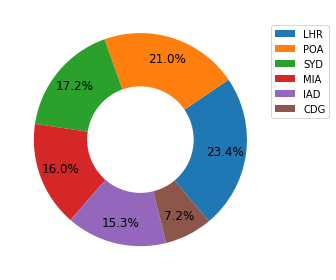

In [14]:

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val==0):
            return 
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

result = df[df['bgp_policy'].str.contains("baseline")].copy()
result.set_index('site',inplace=True)
result.plot(ax=ax, 
            y='percent',
            autopct=make_autopct(result['count']),
            startangle=-50, 
            pctdistance=0.8, 
            kind="pie",
            fontsize=12,
            labels=None)

labels=result.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1.1,0.95))

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle);
ax.set_ylabel('')
fig.tight_layout()
fig.show()
result

---
---
<h1 align="center">Catchment investigation using prepends</h1>

---
---

# OVERALL

## A - positive prepend

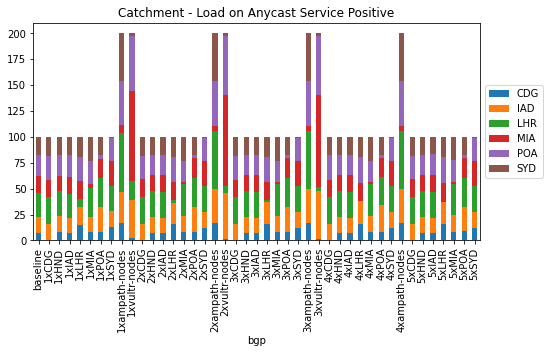

In [15]:
#regex_prepend_site = "^(?!.*negative)(prepend|baseline|all)"
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service Positive");  

## B - negative prepend

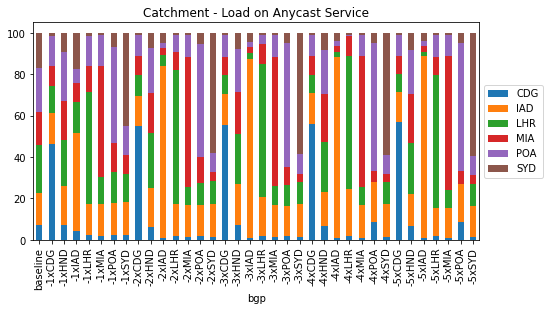

In [16]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']<=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service");  

## C. Impact of path prepending in catchment 

245800.0


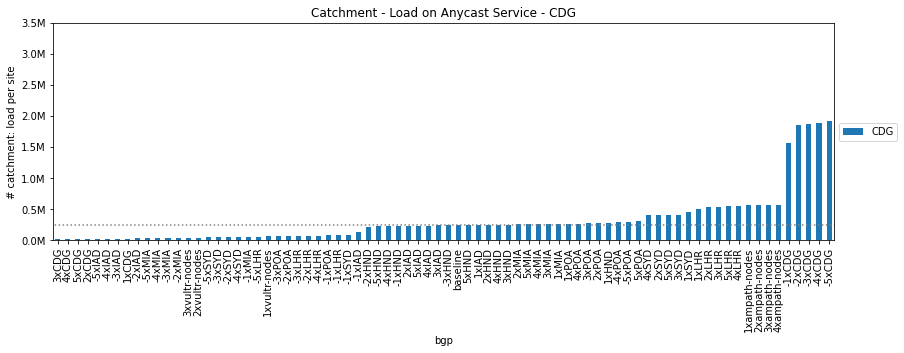

520290.0


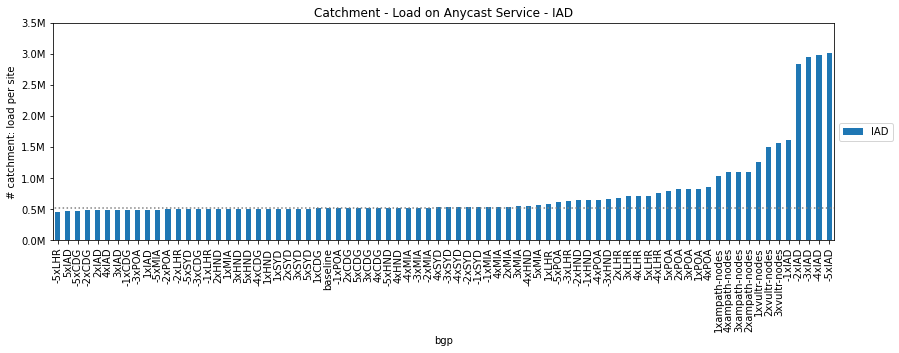

796172.0


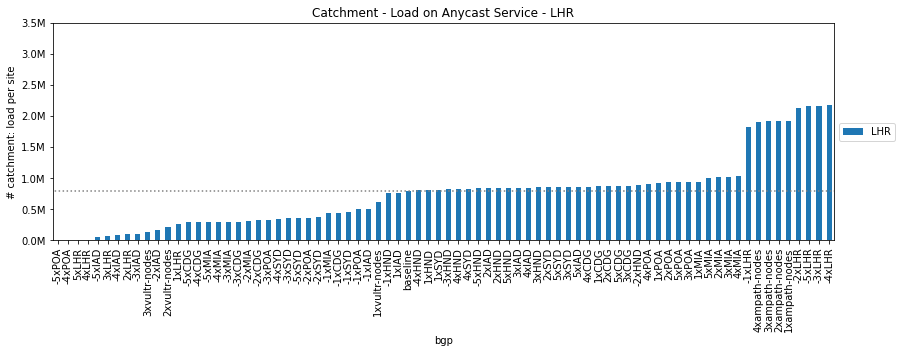

543614.0


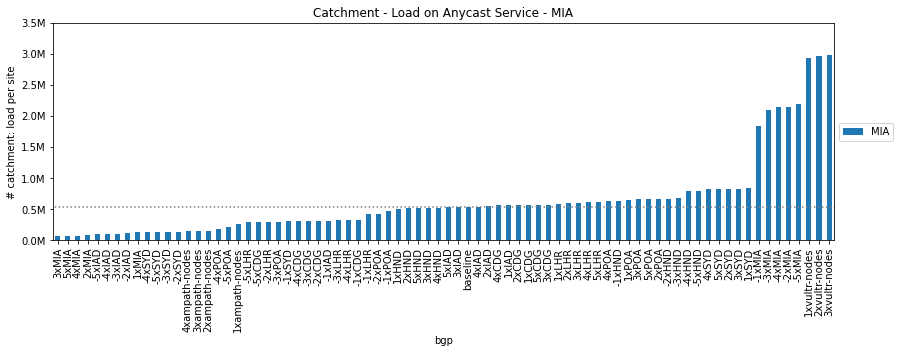

714439.0


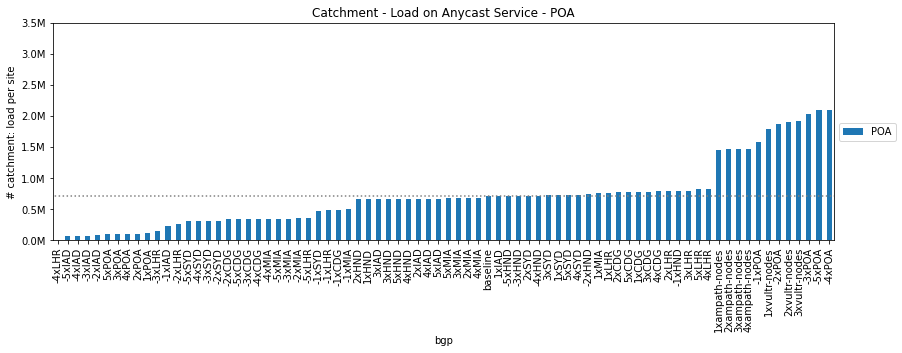

584351.0


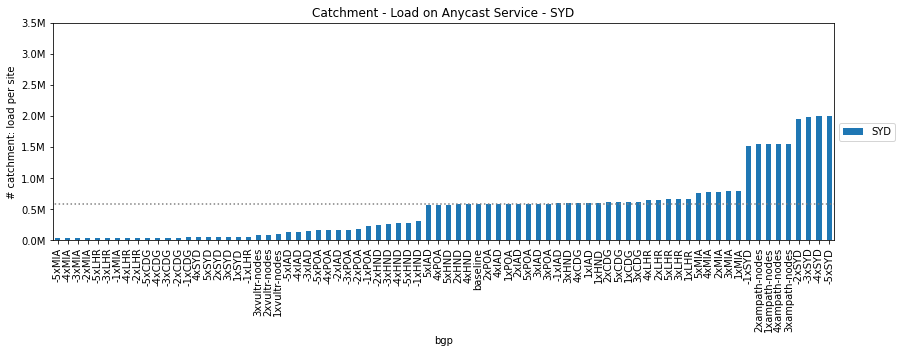

In [17]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
columns_name = data.columns.get_level_values(0)

for col in columns_name:
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    
    data_site = data.loc[:,col].sort_values()
#     data_site = data.loc[:,col] 

    data_site.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
    df_site = data_site.reset_index()
    reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
    print (reference_value)

   # label = "[{}%] BASELINE".format(int(reference_value))
   # ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')
    
    ax.set_ylim(ymax=3500000, ymin=0);
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
#     ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

    ax.set_title("Catchment - Load on Anycast Service - {}".format(col));  
    ax.set_ylabel('# catchment: load per site');
    title = "<h2 style=\"color:#069\" >How prepending affects the load of site: {} </h2>".format(col.upper())
    display(HTML(title))
    plt.show()
    

## same values, another visualization

In [18]:
regex_prepend_site = "prepend|negative|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

#data.drop('unknown',1,inplace=True)    
columns_name = data.columns.get_level_values(0)

In [19]:
print (columns_name)

Index(['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD'], dtype='object', name='site')


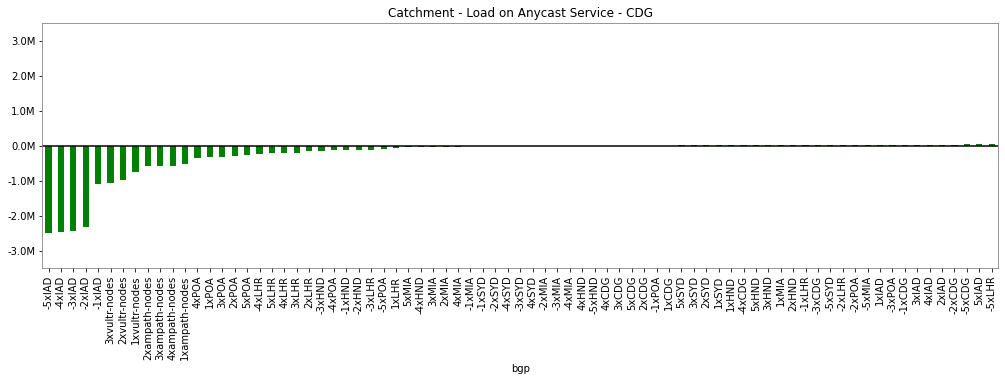

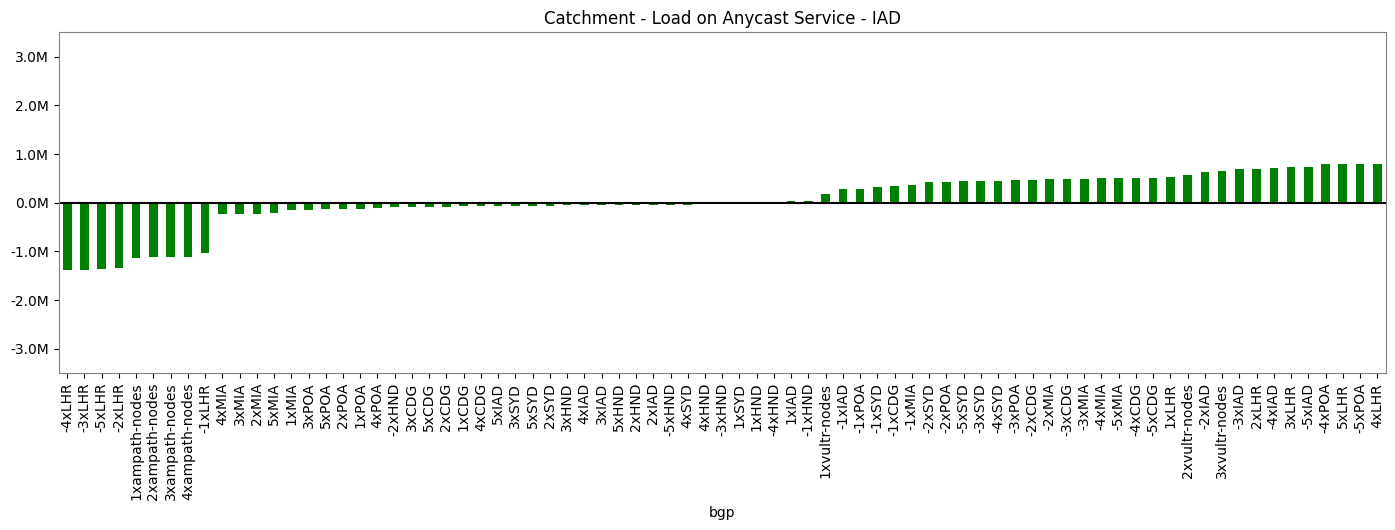

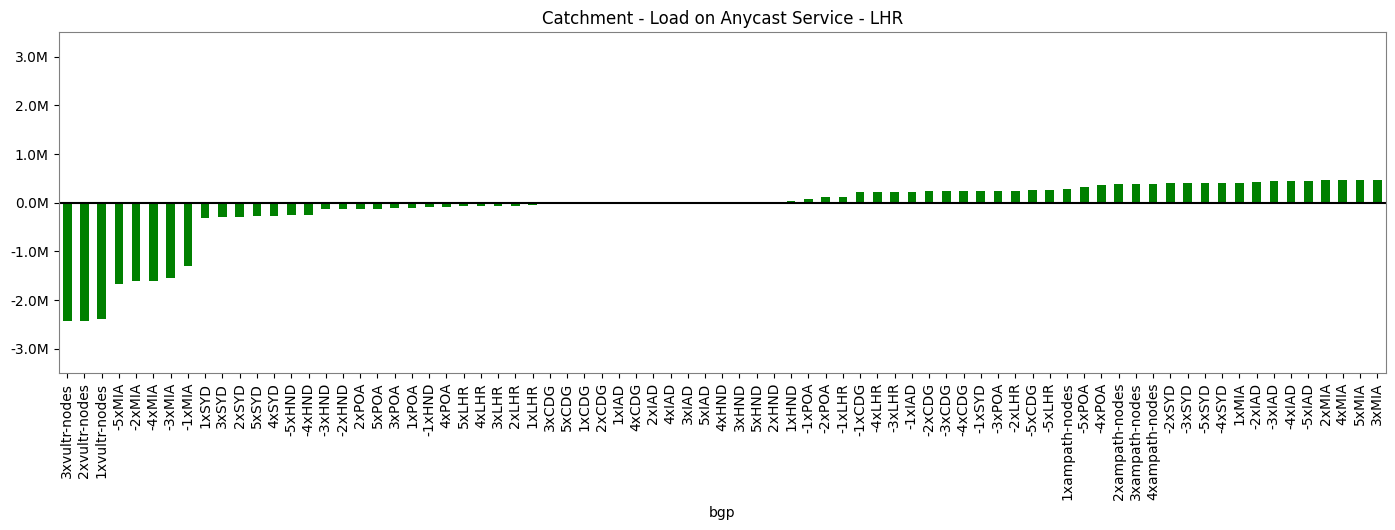

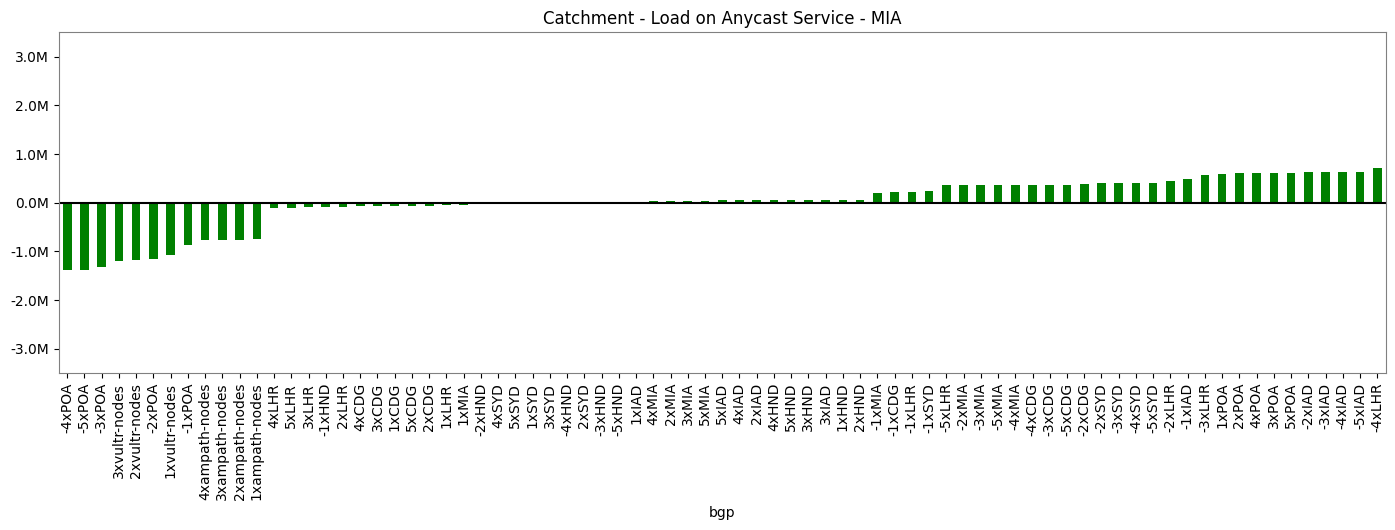

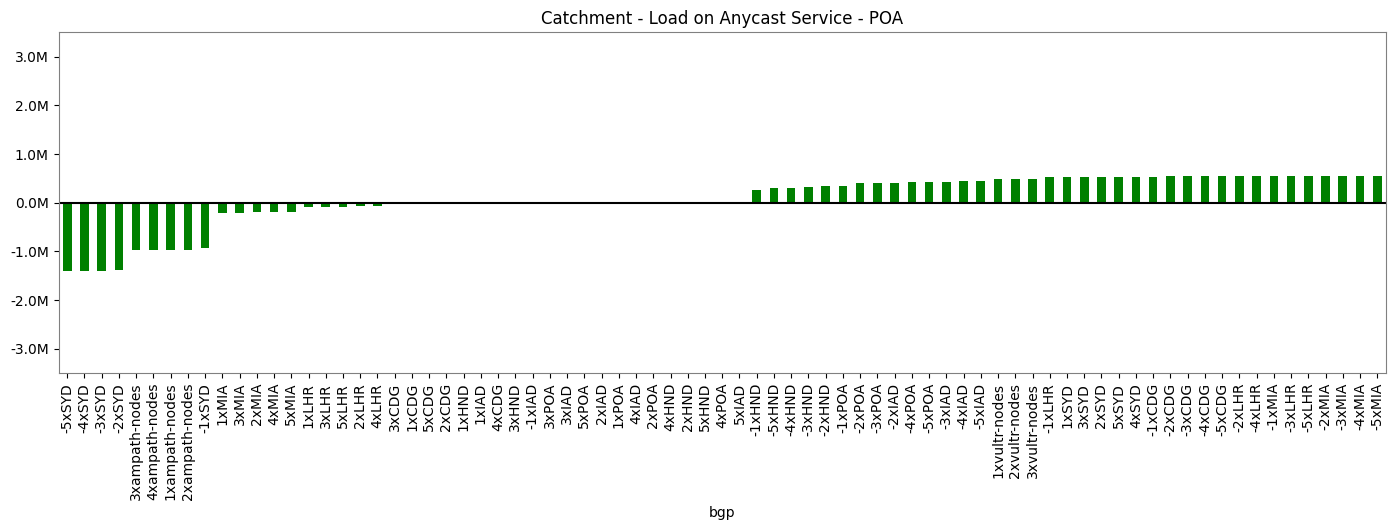

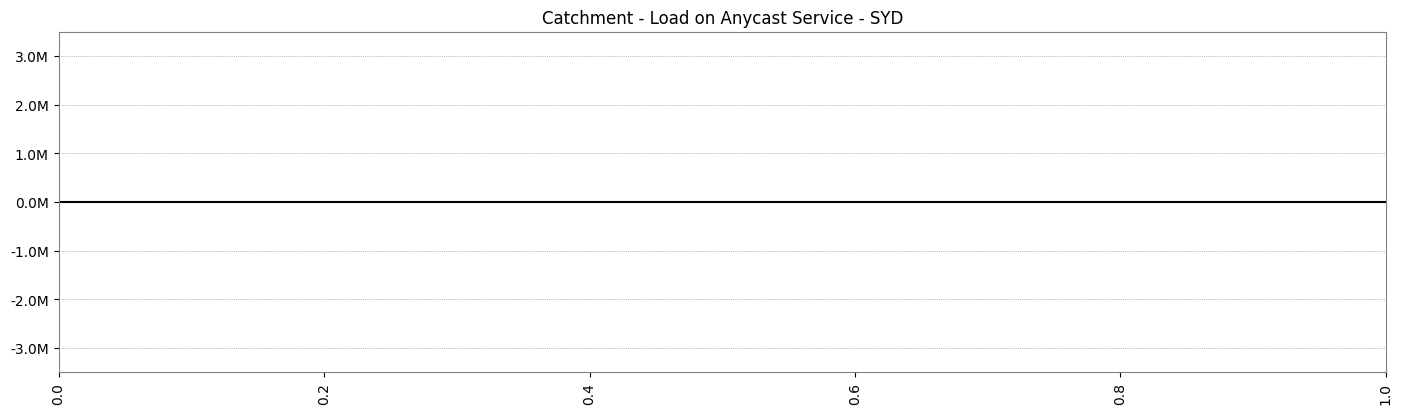

In [20]:
for site in columns_name:
    baseline  = data.iloc[[0]].values[0]
    data_diff = data.iloc[1:].apply(lambda x: (baseline-x), axis=1)  
    data_diff[site].sort_values().plot(kind="bar",ax=ax, stacked=False,color="green")

    (fig,ax) = init_fig(14,4)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels,rotation=90);
    ax.set_ylim(ymax=3500000,ymin=-3500000);
    ax.axhline(y=0, xmin=-1, xmax=1.0, color="black")
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    ax.set_title("Catchment - Load on Anycast Service - {}".format(site)); 
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]); 

## Leandro's Idea
## Anycast Service maximum and minimum

In [21]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

# fix column names
data.columns=data.columns.get_level_values(0)
data.columns = data.columns.to_list()
df_prepend = data
df_prepend.head()

,CDG,IAD,LHR,MIA,POA,SYD
bgp,,,,,,
baseline,245800.0,520290.0,796172.0,543614.0,714439.0,584351.0
-1xCDG,1566418.0,495453.0,443092.0,329853.0,497518.0,47549.0
-1xHND,235341.0,652208.0,759538.0,640007.0,801860.0,315584.0
-1xIAD,141394.0,1614949.0,507450.0,317966.0,231234.0,595158.0
-1xLHR,81971.0,508383.0,1829601.0,419133.0,492276.0,50899.0


In [22]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe.csv",sep=";")

### Extract MAX/MIN/BASELINE from prepend dataframe for each node

In [23]:
# get max value per line
max_policy_label = data.T.idxmax(axis=1)
max_policy_value=data.T.max(axis=1)

# get min value per line
min_policy_label = data.T.idxmin(axis=1)
min_policy_value=data.T.min(axis=1)

# get baseline values
df_baseline = data.iloc[0,:]

# build dataframe
df_result = pd.concat([max_policy_value,
                       min_policy_value,
                       df_baseline,max_policy_label,
                       min_policy_label],
                       axis=1
                     ) 
df_result.columns=['max','min','baseline','max_label','min_label']
# remove nodes
df_result = df_result[df_result.index!="unknown"]
df_result = df_result[df_result.index!="HND"]

,max,min,baseline,max_label,min_label
CDG,1928542.0,0.0,245800.0,-5xCDG,0xCDG
IAD,3015529.0,0.0,520290.0,-5xIAD,0xIAD
LHR,2175304.0,0.0,796172.0,-4xLHR,-4xPOA
MIA,2983336.0,0.0,543614.0,3xvultr-nodes,0xMIA
POA,2104090.0,0.0,714439.0,-4xPOA,0xPOA
SYD,1997357.0,0.0,584351.0,-5xSYD,0xSYD


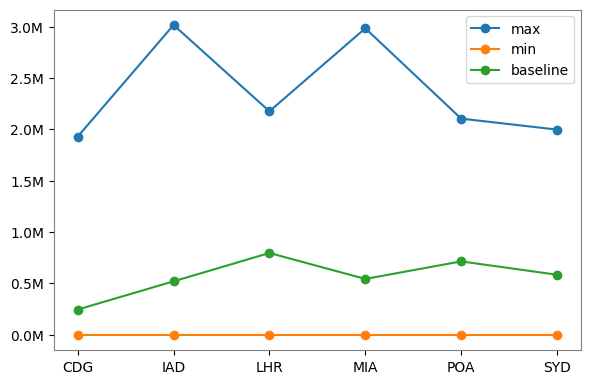

In [24]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)   
ax = plt.subplot2grid((1,1), (0,0))

ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
fig.tight_layout();
plt.style.use('default')

df_result[['max','min','baseline']].plot(marker='o',ax=ax)
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

df_result

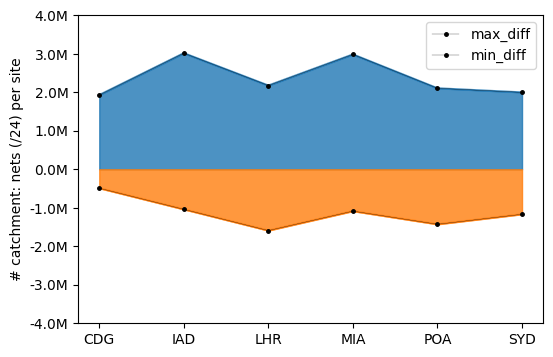

In [25]:
df_result['max_diff'] = (df_result['max'] - df_result['baseline'])   + df_result['baseline']
df_result['min_diff'] = (df_result['min'] - df_result['baseline'] ) - df_result['baseline']
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))
df_result[['max_diff','min_diff']].plot(kind='area',ax=ax,alpha=0.8)
df_result[['min_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
df_result[['max_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
ax.set_ylim(ymax=4000000, ymin=-4000000);
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# catchment: nets (/24) per site');
# ax2 = ax.twinx()
# ax.get_yticks().tolist()


In [26]:
# data_site.iloc[0:1][0]
# data_site[data_site.iloc[0]=="baseline"]

df_site = data_site.reset_index()
reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
reference_value

584351.0

---
---
<h1 align="center">Effect of prepeding on each site</h1>

---
---

In [27]:
available_nodes = df_prepend.columns.to_list()
#available_nodes.remove('unknown')
#available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

In [28]:
df_all[df_all['site']=='jp-hnd-anycast01']

,site,bgp,count,percent,time,active_nodes,bgp_policy,bgp_policy_location,num_prepend,community
5,jp-hnd-anycast01,withdraw-us-was-anycast01,675,0.02,2020-02-05-12:54:36,"au-syd,br-poa,fr-par,jp-hnd,uk-lnd,us-mia",withdraw-us-was-anycast01,us-was,0,None
0,jp-hnd-anycast01,unicast-jp-hnd,3352231,100.00,2020-01-31-23:10:04,jp-hnd,unicast-jp-hnd,jp-hnd,0,None


CDG


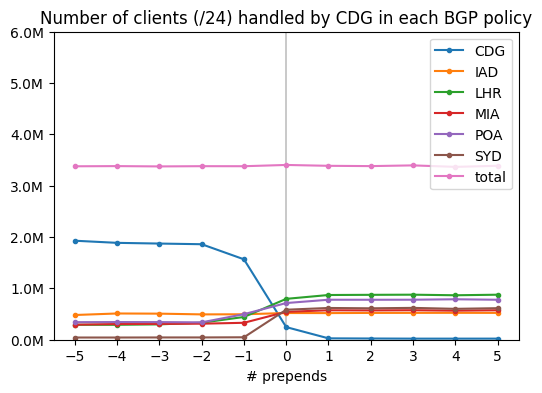

IAD


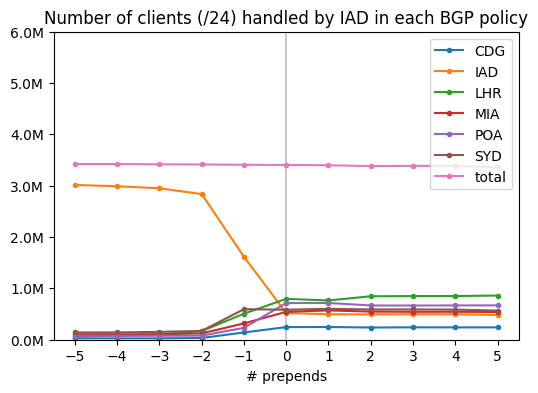

LHR


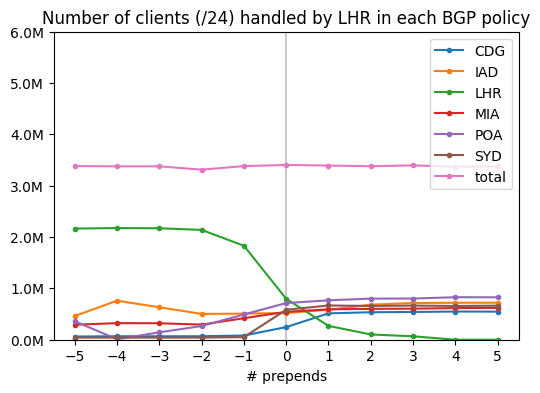

MIA


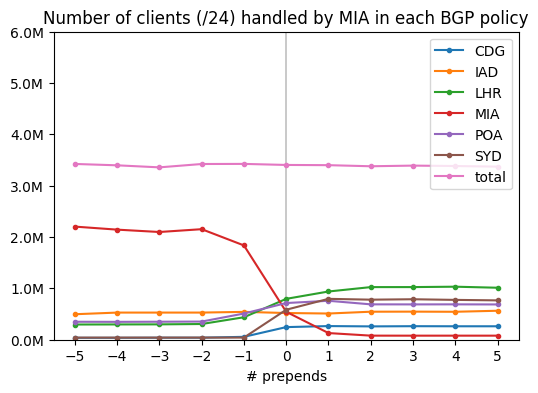

POA


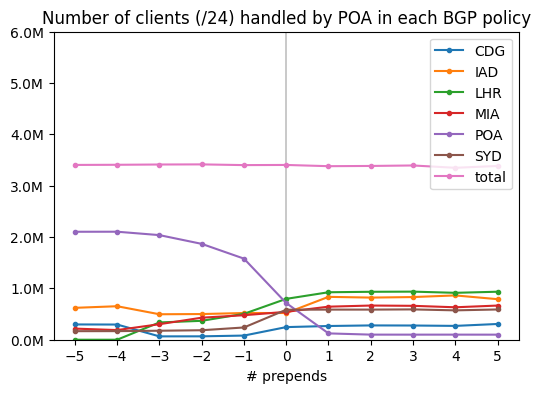

SYD


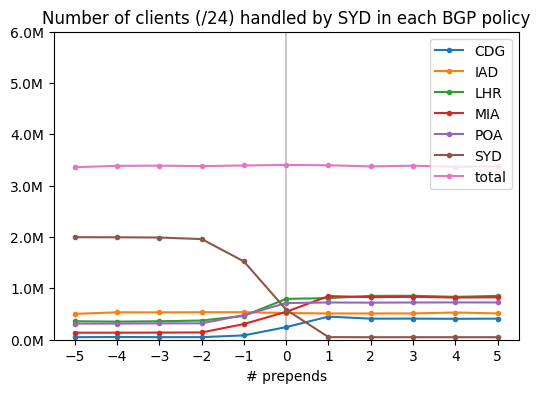

In [29]:
for prepend_site in available_nodes:

    data = df_prepend.copy()
    print (prepend_site)
    # prepare dataframe
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)]
#    data.drop('HND',1,inplace=True)
#    data.drop('unknown',1,inplace=True)
    data.reset_index(inplace=True)
    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    data['total'] = data.sum(axis=1)
    
    # prepare graph
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)   
    ax.set_ylim(ymax=6000000);
    ax.axvline(x=0, color='black',linewidth=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    data.plot(kind="line",ax=ax, marker=".")
    ax.set_xlabel('# prepends');
    ax.set_title("Number of clients (/24) handled by {} in each BGP policy".format(prepend_site));   
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    plt.show()

---
---
<h1 align="center">Effect of self-prepending on all the sites</h1>

---
---

In [30]:
available_nodes = df_prepend.columns.to_list()
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

## By Catchment

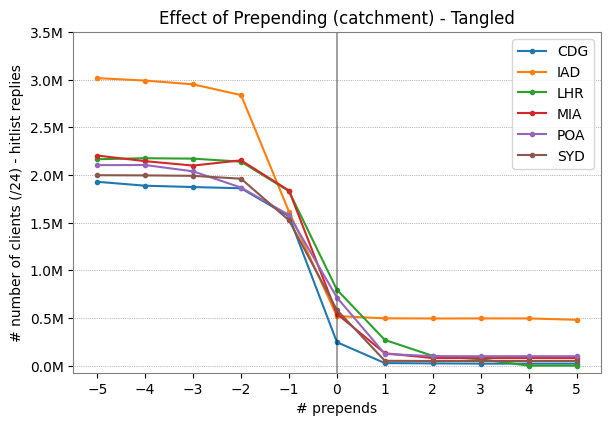

In [31]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (catchment) - Tangled")

for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = df_prepend.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.set_ylim(ymax=3500000);
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))        
    
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    ax.set_ylabel('# number of clients (/24) - hitlist replies');
    ax.set_xlabel('# prepends');

#     filename = "~/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
#    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)

# By Percentage

In [32]:
data = df_prepend.copy()
#data.drop('unknown',1,inplace=True)
data['total'] = data.sum(axis=1)
data_percent = pd.DataFrame()
data_percent['bgp'] = data.index
data = data.reset_index()
data_percent
data.head()

for node in data.columns[1:8]:
    node_pct = "{}_pct".format(node)
    data_percent[node] = (data[node]/data['total']).mul(100).round(3)
    
data_percent.head(1)
data_percent.set_index('bgp',inplace=True)

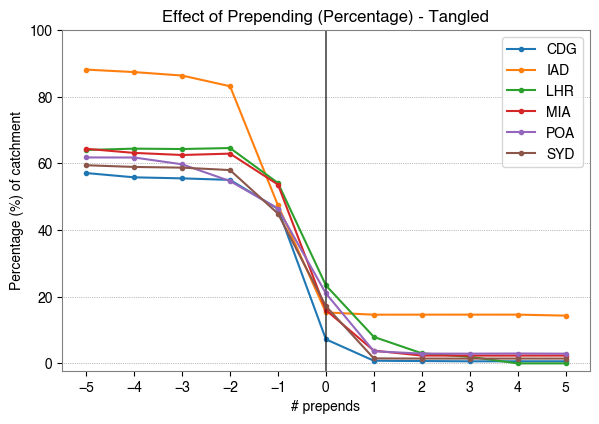

In [33]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

(fig,ax) = init_fig(6,4)

plt.rcParams.update({'font.sans-serif':'Helvetica'})
ax.set_title("Effect of Prepending (Percentage) - Tangled")

#available_nodes = ['CDG', 'LHR', 'MIA', 'POA', 'SYD']
available_nodes=data_percent.columns.to_list()
if 'total' in available_nodes:
    available_nodes.remove('total')
#print(available_nodes)

for prepend_site in available_nodes:

    # prepare dataset
    data = data_percent.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()
    

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_ylabel('Percentage (%) of catchment');
    ax.set_xlabel('# prepends');
    ax.set_ylim(ymax=100);
    #plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.axvline(x=0, color='black',linewidth=0.1)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    
    #filename = "/Users/bertholdo/PAPERS/ddos_anycast/USENIX/FIG/TANGLED/self_prepending_tangled_v2.pdf"
    #ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    #fig.savefig(filename, bbox_inches='tight', dpi=1200)

---
---
<h1 align="center">End</h1>

---
---